<a href="https://colab.research.google.com/github/SurajKumar2235/LLM_fineTuning/blob/main/Updated%20LLama%207b%20fine%20tuning%20using%20openorca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.loom.com/share/ee4abf4659984733a00f932962e914d5?sid=9bcd268a-c441-409d-93c3-29e181d4b02a   loom vedio link

In [1]:
%pip install datasets  torch

# PREPARING DATASETS FOR FINE TUNING THE MODEL

In [8]:

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from  datasets import load_dataset
df= load_dataset('Open-Orca/OpenOrca')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
import pandas as pd


sliced_df=df['train'].select(range(2000))
sliced_df

Dataset({
    features: ['id', 'system_prompt', 'question', 'response'],
    num_rows: 2000
})

In [ ]:
df=pd.DataFrame(sliced_df)
df

,id,system_prompt,question,response
0,niv.242684,,You will be given a definition of a task first...,"[\n [""AFC Ajax (amateurs)"", ""has ground"", ""Sp..."
1,flan.564327,You are an AI assistant. You will be given a t...,Generate an approximately fifteen-word sentenc...,Midsummer House is a moderately priced Chinese...
2,flan.1875913,"You are a helpful assistant, who always provid...",What happens next in this paragraph?\n\nShe th...,C. She then dips the needle in ink and using t...
3,t0.408370,You are an AI assistant. You will be given a t...,Please answer the following question: I want t...,"Based on the passage, discuss the primary moti..."
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e..."
...,...,...,...,...
1995,t0.272483,You are an AI assistant that follows instructi...,Suggest a movie title for the following movie ...,"Title Suggestion: ""Taran and the Quest for the..."
1996,t0.779540,You are an AI assistant. User will you give yo...,Pick from:\n(A). A month;\n(B). not enough inf...,C. A day;\n\nSince soccer games typically last...
1997,t0.755786,You are an AI assistant. User will you give yo...,Q:I want to test the ability of students to re...,Question: Who was the first black female diver...
1998,cot.74732,You are an AI assistant that helps people find...,"Consider the question. While in New York, she ...",Mary Camden marries Carlos Rivera in 7th Heave...


In [ ]:
df.isna().sum()

id               0
system_prompt    0
question         0
response         0
dtype: int64

### droping row which have response <100 word count

In [ ]:

def remove_short_responses(df):

  df['response_token_count'] = df['response'].apply(lambda x: len(word_tokenize(x)))
  df = df[df['response_token_count'] >= 100]
  del df['response_token_count']
  return df

df = remove_short_responses(df)


In [ ]:
df

,id,system_prompt,question,response
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e..."
5,cot.18180,You are an AI assistant that helps people find...,"Given the stream of consciousness rationale, p...",Question: What is the proper technique for a f...
6,flan.2136716,You are an AI assistant. User will you give yo...,Multi-choice question: What is the sentiment o...,"To determine the sentiment of the tweet, we ne..."
7,cot.84626,You are an AI assistant that helps people find...,"John was a terrible writer. To practice, his ...",Step 1: Analyze the situation - John is a terr...
12,t0.700360,You are an AI assistant. User will you give yo...,Given the question: I am trying to decide whet...,Tool is a character in The Expendables movie a...
...,...,...,...,...
1983,flan.2298248,You are an AI assistant. User will you give yo...,What happens if I change my android's mac adre...,The two questions you have asked are fundament...
1985,flan.1317099,You are an AI assistant. You will be given a t...,Write down the solution for this math problem:...,To solve the equation -10*p - 2114 = -2154 for...
1986,flan.1455166,"You are a helpful assistant, who always provid...",Write an article based on this summary:\n\nReg...,Title: How to Create Your Own Online Forum: A ...
1988,flan.2061287,"You are a helpful assistant, who always provid...",Write an article based on this summary:\n\nAdd...,Title: Taking Care of Your Garden: Tips for He...


### finding the similar response and droping it

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

responses = df['response'].tolist()

vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(responses)

cosine_matrix = cosine_similarity(vectors)

In [ ]:

duplicate_indices = []
to_drop=[]

for i in range(len(cosine_matrix)):
  for j in range(i + 1, len(cosine_matrix)):
    if cosine_matrix[i][j] > .95:
      duplicate_indices.append((i, j))
      to_drop.append(j)


In [ ]:
duplicate_indices,to_drop

([], [])

In [ ]:
df.columns

Index(['id', 'system_prompt', 'question', 'response'], dtype='object')

In [ ]:
df=df.drop(df.index[to_drop])

## converting the data in proper response in which previous data is trained

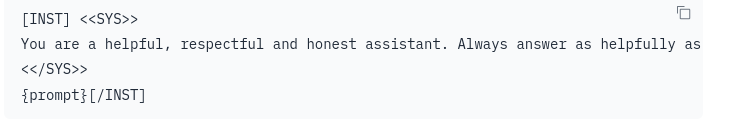


In [ ]:

df['conversation'] = "[INST]<<SYS>>"+" "+df["system_prompt"]+ "<</SYS>> " +"<|user|> "+df["question"] + "<|assistant|> " + df["response"]+"[/INST]"
df.head()


,id,system_prompt,question,response,conversation
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e...",[INST]<<SYS>> You are an AI assistant that hel...
5,cot.18180,You are an AI assistant that helps people find...,"Given the stream of consciousness rationale, p...",Question: What is the proper technique for a f...,[INST]<<SYS>> You are an AI assistant that hel...
6,flan.2136716,You are an AI assistant. User will you give yo...,Multi-choice question: What is the sentiment o...,"To determine the sentiment of the tweet, we ne...",[INST]<<SYS>> You are an AI assistant. User wi...
7,cot.84626,You are an AI assistant that helps people find...,"John was a terrible writer. To practice, his ...",Step 1: Analyze the situation - John is a terr...,[INST]<<SYS>> You are an AI assistant that hel...
12,t0.700360,You are an AI assistant. User will you give yo...,Given the question: I am trying to decide whet...,Tool is a character in The Expendables movie a...,[INST]<<SYS>> You are an AI assistant. User wi...


In [ ]:

df["conversation"][:5]

4     [INST]<<SYS>> You are an AI assistant that hel...
5     [INST]<<SYS>> You are an AI assistant that hel...
6     [INST]<<SYS>> You are an AI assistant. User wi...
7     [INST]<<SYS>> You are an AI assistant that hel...
12    [INST]<<SYS>> You are an AI assistant. User wi...
Name: conversation, dtype: object

## uploding the data into hugging face hub

In [ ]:
df.to_csv('mydata.csv')

In [ ]:
df['conversation'].to_csv('myConversation.csv',index=False)

In [ ]:
pd.read_csv('/content/myConversation.csv').columns

Index(['conversation'], dtype='object')

In [ ]:
from datasets import Dataset

# Load CSV into a Dataset object
dataset = Dataset.from_csv("/content/myConversation.csv")

# Upload the dataset to the Hugging Face Data Hub
dataset.push_to_hub("OpenOrca")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MindonFire/OpenOrca/commit/95cf4fa344dd7003696e813c7469fff5668df8a7', commit_message='Upload dataset', commit_description='', oid='95cf4fa344dd7003696e813c7469fff5668df8a7', pr_url=None, pr_revision=None, pr_num=None)

Uploaded Dataset     https://huggingface.co/datasets/MindonFire/OpenOrca/

#RESTART NEW SESSION


###from here we can restart our model building and fine tuning using peft ---> LORA

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00


In [3]:

from huggingface_hub import notebook_login

notebook_login()

# importing Data from Prepared Data

In [4]:
from datasets import load_dataset
dataset = load_dataset("MindonFire/OpenOrca")

In [ ]:
# import transformers
# import torch
# from transformers import  BitsAndBytesConfig, AutoTokenizer, Trainer, TrainingArguments,AutoConfig

In [ ]:
# from transformers import  AutoModelForCausalLM

# Installing Dependencies

In [8]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2  trl==0.4.7

In [10]:
!pip install trl

# importing Requierred Libraries

In [12]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
import torch


In [ ]:
!pip install trl

### Setting Fine Tuning parameter

In [13]:
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}


model_name='daryl149/llama-2-7b-hf'

In [14]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [15]:
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)



tokenizer_config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 939
    })
})

In [17]:
# Set supervised fine-tuning parameters
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    peft_config=peft_config,
    dataset_text_field="conversation",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/939 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.499500
50,1.222400
75,1.262100
100,1.124300
125,1.155400
150,1.109000
175,1.229300
200,1.079800


Step,Training Loss
25,1.499500
50,1.222400
75,1.262100
100,1.124300
125,1.155400
150,1.109000
175,1.229300
200,1.079800
225,1.174400


TrainOutput(global_step=235, training_loss=1.2010499751314203, metrics={'train_runtime': 1722.0258, 'train_samples_per_second': 0.545, 'train_steps_per_second': 0.136, 'total_flos': 1.004199865368576e+16, 'train_loss': 1.2010499751314203, 'epoch': 1.0})

In [23]:

from huggingface_hub import notebook_login

notebook_login()

In [29]:
!pip install git+https://github.com/huggingface/transformers.git -q -U # transformers version:  4.37.0
!pip install git+https://github.com/huggingface/accelerate.git -q -U # accelerate version:  0.27.0
!pip install bitsandbytes # bitsandbytes version:  0.42.0
!pip install git+https://github.com/huggingface/peft.git -q -U # peft version: 0.7.2


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [32]:


prompt = "What is Python?"

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
max_length = 512
output = model.generate(input_ids=input_ids, max_length=max_length)[0]

print(tokenizer.decode(output))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will

<s> What is Python?
 Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability, and its syntax allows programmers to express concepts in fewer lines of code than possible in languages such as C++ or Java.

Python is a dynamic language, which means that it is not always necessary to declare variables before using them. This makes it easier to write code and reduces the number of errors that can occur.

Python is also an interpreted language, which means that it is not compiled into machine code before execution. Instead, the Python interpreter reads the source code and executes it line by line. This makes it easier to debug and modify code, as well as to experiment with new ideas.

Python is widely used in many fields, including web development, scientific computing, data analysis, and artificial intelligence. It is also used in education, as it is easy to learn and has a large community of developers and resources available.

Python